# Imports

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics.pairwise import cosine_similarity

# Load Data

In [39]:
# Load datasets
base_dir = 'data/'

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Load the data
train_dataset_ = image_dataset_from_directory(train_dir, image_size=(224, 224), batch_size=32)
valid_dataset_ = image_dataset_from_directory(valid_dir, image_size=(224, 224), batch_size=32)
test_dataset_ = image_dataset_from_directory(test_dir, image_size=(224, 224), batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset_.class_names

# Preprocess the datasets
train_dataset = train_dataset_.map(lambda x, y: (preprocess_input(x), y))
valid_dataset = valid_dataset_.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset_.map(lambda x, y: (preprocess_input(x), y))

Found 3467 files belonging to 8 classes.
Found 382 files belonging to 8 classes.
Found 7 files belonging to 1 classes.


# Visualize Data

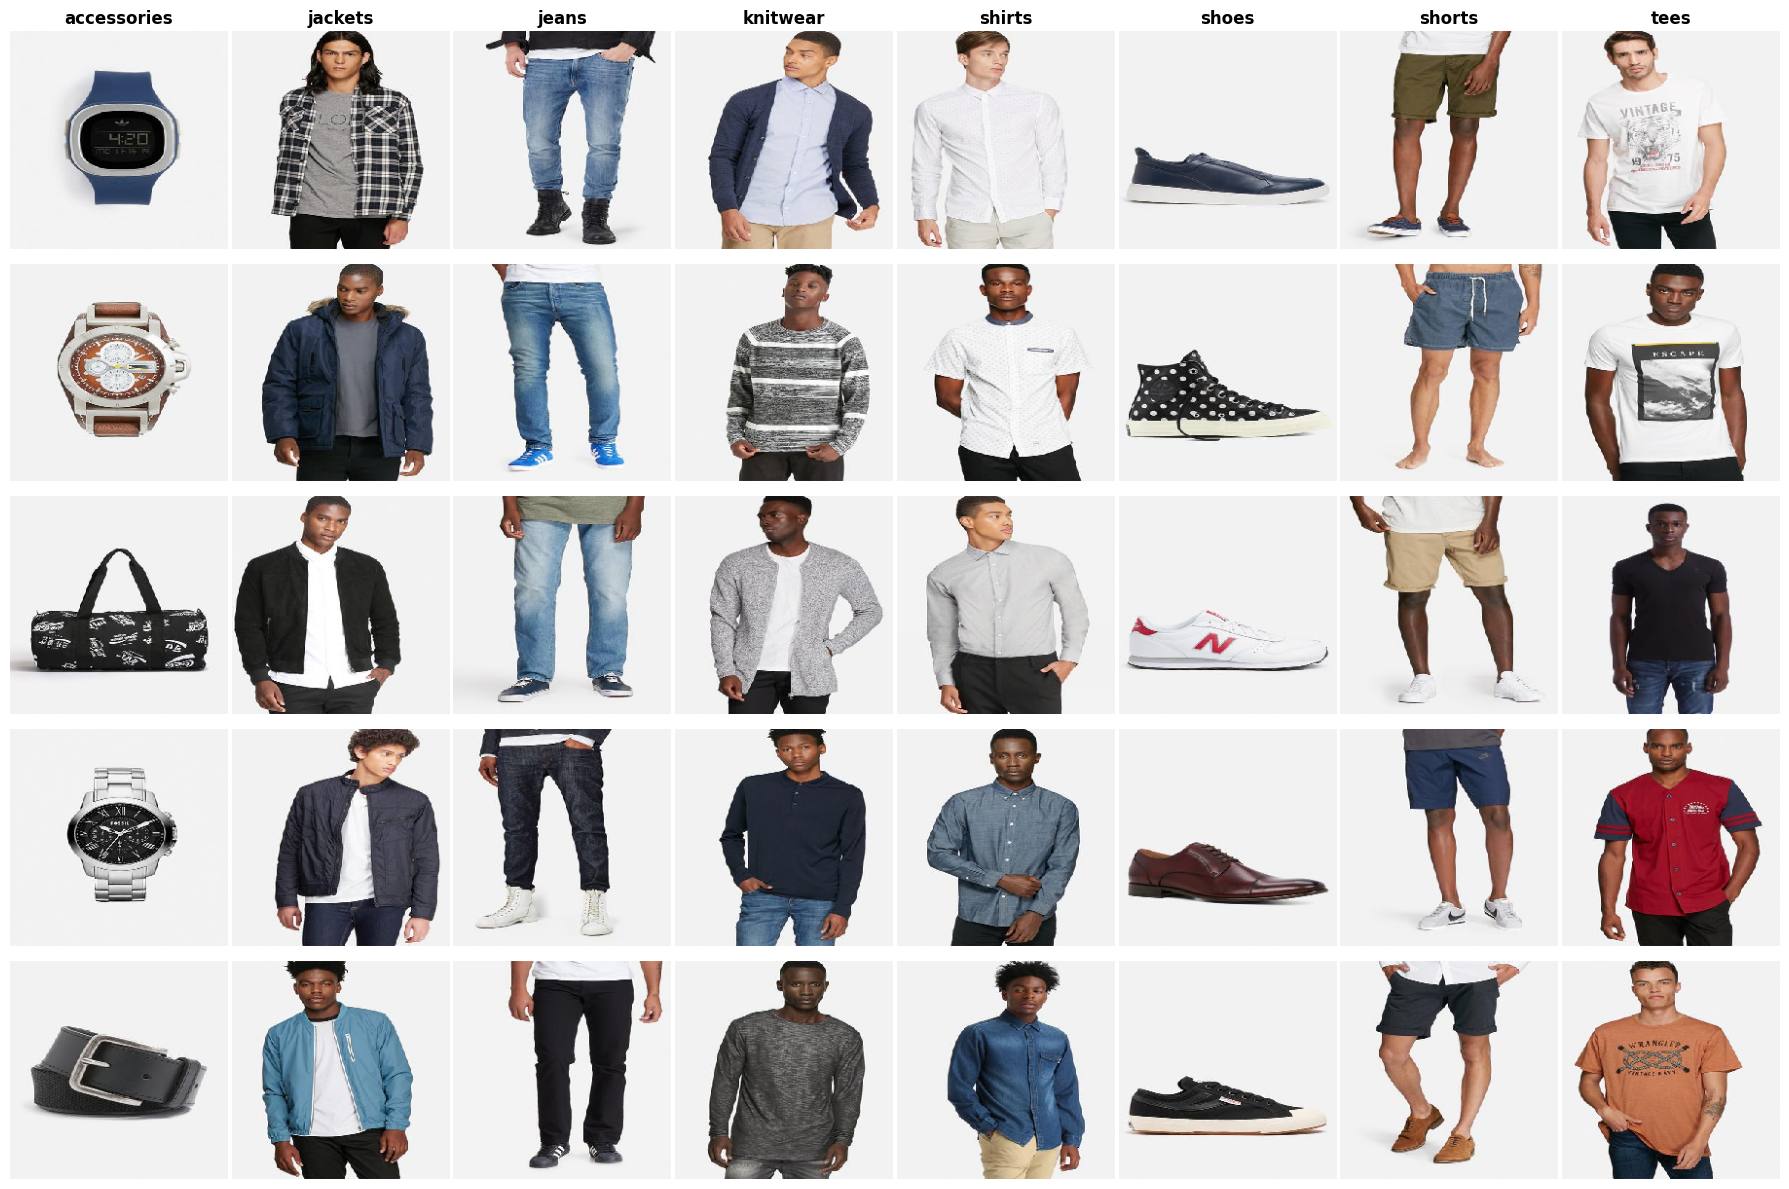

In [40]:
# Set the base directory for the training dataset
train_dir = 'data/train'

# Define categories (subdirectory names) based on the directory structure
categories = ['accessories', 'jackets', 'jeans', 'knitwear', 'shirts', 'shoes', 'shorts', 'tees']

# Set up the figure with a larger figsize for bigger images and reduce space between plots
fig, axes = plt.subplots(5, 8, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Loop over each category
for col, category in enumerate(categories):
    # Get sample images from each category
    category_dir = os.path.join(train_dir, category)
    sample_images = os.listdir(category_dir)[:5]  # Get the first 3 images
    
    # Loop over each sample image and plot it
    for row, image_file in enumerate(sample_images):
        img_path = os.path.join(category_dir, image_file)
        img = load_img(img_path, target_size=(224, 224))  # Load and resize the image
        img_array = img_to_array(img) / 255.0  # Normalize the image for display

        # Plot the image in the correct subplot
        axes[row, col].imshow(img_array)
        axes[row, col].axis('off')
        if row == 0:
            axes[row, col].set_title(category, fontsize=12, fontweight='bold')  # Bold and larger title

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Train model

In [ ]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for saving the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10, callbacks=[checkpoint])

# Load the best model
model.load_weights('best_model.keras')

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7584 - loss: 0.7600
Epoch 1: val_accuracy improved from -inf to 0.95026, saving model to best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 80s 717ms/step - accuracy: 0.7595 - loss: 0.7567 - val_accuracy: 0.9503 - val_loss: 0.1754
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9577 - loss: 0.1332
Epoch 2: val_accuracy did not improve from 0.95026
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 712ms/step - accuracy: 0.9576 - loss: 0.1332 - val_accuracy: 0.9503 - val_loss: 0.1359
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9698 - loss: 0.0950

In [ ]:
# Evaluate on validation set
loss, accuracy = model.evaluate(valid_dataset)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Visualize Predictions

In [ ]:
# Function to get image paths and their corresponding labels from the validation directory
def load_data(path):
    image_paths = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(path, class_name)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_idx)  # The label is the index of the folder (e.g., 0 for 'accessories')
    return image_paths, labels

# Load validation data
image_paths, true_labels = load_data(valid_dir)

# Function to preprocess images and generate predictions
def predict_images(image_paths):
    predictions = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)  # Preprocess as required by ResNet50
        pred = model.predict(img_array)
        predictions.append(np.argmax(pred, axis=1)[0])
    return predictions

# Generate predictions for the validation set
predicted_labels = predict_images(image_paths)

In [ ]:
# Separate correct and incorrect predictions
correct_indices = [i for i in range(len(predicted_labels)) if predicted_labels[i] == true_labels[i]]
incorrect_indices = [i for i in range(len(predicted_labels)) if predicted_labels[i] != true_labels[i]]

# Function to plot the images in a grid
def plot_grid(indices, title, rows=2, cols=8):
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6))
    for i, idx in enumerate(indices[:rows * cols]):
        img = load_img(image_paths[idx], target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalize for display

        predicted_label = class_names[predicted_labels[idx]]
        actual_label = class_names[true_labels[idx]]

        # Plot the image
        ax = axes[i // cols, i % cols]
        ax.imshow(img_array)
        ax.set_title(f'Pred: {predicted_label}\nActual: {actual_label}', fontsize=10)
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot correct predictions
plot_grid(correct_indices, 'Correct Predictions')

# Plot incorrect predictions
plot_grid(incorrect_indices, 'Incorrect Predictions')

# Visual Image Search

## Embed the training data

In [ ]:
# Use the ResNet50 base model to generate embeddings
embedding_model = Model(inputs=base_model.input, outputs=base_model.output)  

# Function to generate embeddings
def generate_embedding(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    embedding = embedding_model.predict(img_array, verbose=0)  # Get embedding from base model
    embedding = embedding.flatten()  # Flatten the embedding to a 1D vector
    return embedding

# Generate embeddings for all images in the training set
train_image_paths, _ = load_data(train_dir)  # Using the previous load_validation_data function for training set
train_embeddings = [generate_embedding(img_path) for img_path in train_image_paths]

In [ ]:
# Function to find top 10 most similar images from the training set
def find_similar_images(test_image_path, train_image_paths, train_embeddings, top_n=10):
    # Get the embedding for the test image
    test_embedding = generate_embedding(test_image_path)

    # Compute cosine similarity between test embedding and all training embeddings
    similarities = cosine_similarity([test_embedding], train_embeddings)[0]

    # Get indices of top N most similar images
    top_n_indices = np.argsort(similarities)[-top_n:][::-1]
    
    return top_n_indices, similarities[top_n_indices]

In [ ]:
# Function to plot the input image and then the top N similar images in a separate plot
def plot_input_and_similar_images(test_image_path, top_n_indices, train_image_paths, title='Top 10 Similar Images'):
    # Plot the test (input) image separately
    fig, ax_test = plt.subplots(figsize=(4, 4))
    test_img = load_img(test_image_path, target_size=(224, 224))
    ax_test.imshow(test_img)
    ax_test.set_title('Input Image', fontsize=16)
    ax_test.axis('off')
    plt.show()

    # Plot the top 10 most similar images in a 5x2 grid
    fig, axes = plt.subplots(2, 5, figsize=(18, 6))  # 5x2 grid for similar images
    for i, idx in enumerate(top_n_indices):
        img_path = train_image_paths[idx]
        img = load_img(img_path, target_size=(224, 224))
        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(f"Rank {i+1}", fontsize=12)
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def run_visual_search(path):
    top_n_indices, top_similarities = find_similar_images(path, train_image_paths, train_embeddings, top_n=10)
    plot_input_and_similar_images(path, top_n_indices, train_image_paths)

In [ ]:
run_visual_search('data/test/unknown/test6.jpg')

In [ ]:
run_visual_search('data/test/unknown/test5.jpg')